**Table of contents**<a id='toc0_'></a>   
- 1. [Imports](#toc1_)     
- 2. [IS-LM model](#toc2_)    
- 3. [Solution and simulation](#toc3_)    
- 4. [Without Government](#toc4_)  
 4.1. [Simulation](#toc4_1_)      
- 5. [Model with Government](#toc5_)    
- 6. [Affect of Government Spending Spree](#toc6_)    


## 1. <a id='toc1_'></a>[Imports](#toc1_)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from matplotlib import cm
from matplotlib import rc
import matplotlib.ticker as ticker
import ipywidgets as widgets
from ISLMModel import ODESolver
from ISLMModel import RungeKutta4
from ISLMModel import ForwardEuler


C:\Users\Janze\AppData\Local\Temp\ipykernel_30416\3832628717.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## 2. <a id='toc2_'></a>[IS-LM model](#toc2_)

The Investment-Savings (IS) Liquidity Preference-Money Supply (LM) model is a Keynesian macroeconomic framework that depicts the interaction between the goods market and the money market to determine the equilibrium between interest rates and total economic output in the economy. It provides a simplified representation of the economy, enabling policymakers to gain insights into stimulating economic activity through the behavior of various economic agents.

In the IS-LM model, we begin with the goods market. As per basic economics, the Gross Domestic Product (GDP) at any given time (t) is the sum of household consumption, investment, government spending, and net exports. For this model, we assume a closed economy, meaning there is no international trade, and the country operates in an independent economy.

\begin{align*}
Y(t) = C(t) + I(t) + G(t) \tag{1}                      
\end{align*}

Household consumption $C(t)$ is given as:

\begin{align*}
C(t) = a + bY_d(t) \tag{2}                      
\end{align*}

Disposable income of households refer to the difference between $Y(t)$ and total taxes $T(t)$.

\begin{align*}
Y_d(t) = Y(t) - T(t) \tag{3}
\end{align*}

The level of taxes $T(t)$ is described by the sum of the fixed taxes $T$ and the variable taxes given as a percentange $\lambda$ multiplied with GDP $Y(t)$.

\begin{align*}
T(t) = T + \lambda Y(t) \tag{4}
\end{align*}

The total amount of investment at any time $t$ refers to the difference between the level of autonomous investments $I_o$ and the product of the sensitivity of the investment in relation to the interest rate $h$ and the real interest rate $r$.

\begin{align*}
I(t) = I_o - h r(t) \tag{5}
\end{align*}

Lastly, we set government expenditure as fixed.

\begin{align*}
G(t) = \bar{G} \tag{6}
\end{align*}


The money market:

The demand for money, denoted as $M_d(t)$, can be expressed as the sum of the autonomous demand for money ($M_o$) and the product of the sensitivity of the demand for money to output ($k$) and the Gross Domestic Product ($Y(t)$). However, the demand for money is inversely related to the interest rate ($r$), with the reduction in demand being proportional to the sensitivity of the demand for money to the interest rate ($\mu$) multiplied by the interest rate itself.

\begin{align*}
M_d(t) = M_o + k Y(t) - \mu r(t) \tag{7}
\end{align*}

The money supply in the economy is fixed.

\begin{align*}
M_s(t) = \bar{M} \tag{8}
\end{align*}

Lastly, we have the market clearing condition that the demand for money must equal to the supply for money.

\begin{align*}
M_d(t) = M_s(t) \tag{9}
\end{align*}


We attempt to model the change in output $Y(t)$ with respect to time $t$ by taking the derivative of $Y$ with respect to $t$:

\begin{align*}
\frac{dy}{dt} = \alpha(C(t) + I(t) + G(t) - Y(t)) \tag{10}
\end{align*}

where $\alpha$ refers to the speed of adjustment to equilibrium in the goods market.

We now derive the differential equations that explains the change of output (GDP) over time, following the IS-LM model.

Plugging in equation 2-6 we get:

\begin{align*}
\frac{dy}{dt} = \alpha(a + bY_d(t) + I_o - hr(t) + \bar{G} - Y(t)) 
\end{align*}

\begin{align*}
\frac{dy}{dt} = \alpha(a + b(Y(t) - T(t)) + I_o - hr(t) + \bar{G} - Y(t)) 
\end{align*}

\begin{align*}
\frac{dy}{dt} = \alpha(a + b(Y(t) - (T_o + \lambda Y(t))) + I_o - hr(t) + \bar{G} - Y(t)) 
\end{align*}

\begin{align*}
\frac{dy}{dt} = \alpha(a - bT_o + I_o + \bar{G}) - \alpha((1-b)(1-\lambda)Y(t)) - \alpha hr(t) \tag{11}
\end{align*}

We do the same thing to formulate a differential equation that explains the change in real interest rates over time:

\begin{align*}
\frac{dr}{dt} = \beta(M_d(t) - M_s(t)) 
\end{align*}

where $\beta$ refers to the speed of adjustment to equilibrium in the money market.

The IS-LM model assumes that $\beta > \alpha$.

Plugging in equation 7-9, we get:

\begin{align*}
\frac{dr}{dt} = \beta(M_o + k Y(t) - \mu r(t) - \bar{M}) 
\end{align*}

\begin{align*}
\frac{dr}{dt} = \beta(M_o - \bar{M} + k Y(t) - \mu r(t)) \tag{12}
\end{align*}


The system of ordinary differential equations that we will be modeling in this notebook is represented by equations 11 and 12. These equations depend on the variables Y(t) and r(t), which are the endogenous variables in this dynamic model.

In contrast, the variables $T$, $I_o$, and $M_o$ are policy variables that are treated as exogenous in the IS-LM model. 

### 3. <a id='toc3_'></a>[Comparing different estimation solvers](#toc3_)

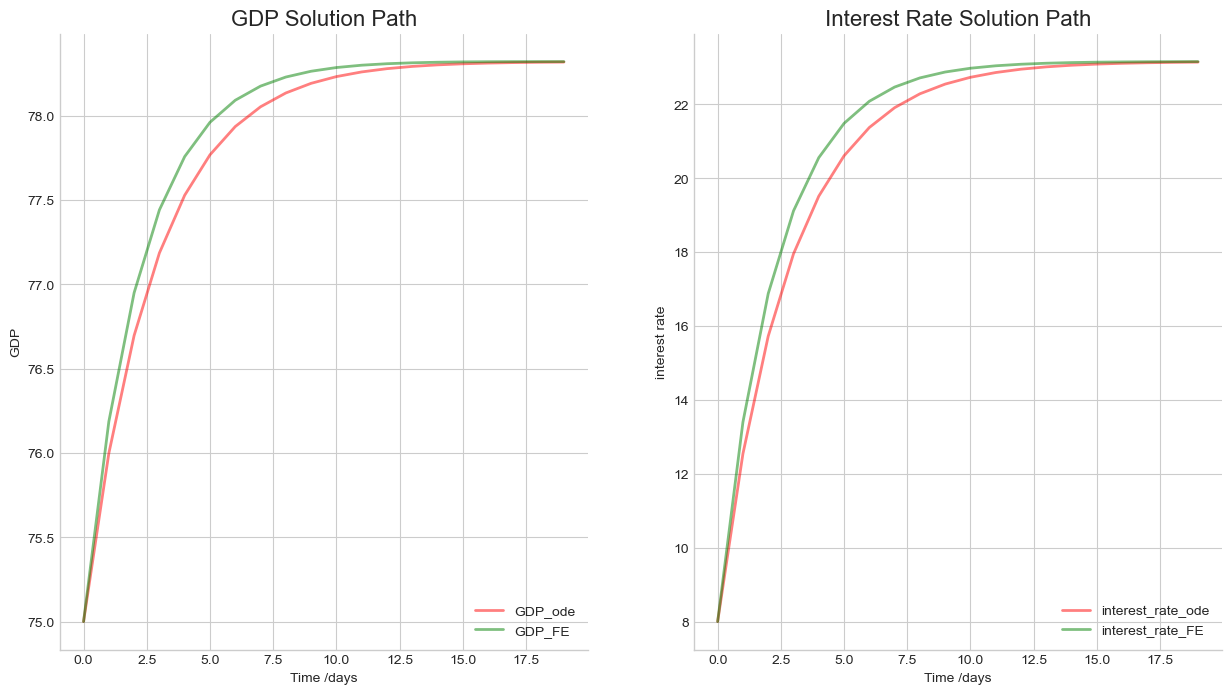

In [28]:
#Parameters for the model

a = 15 # consumption
I_0 = 10 # investment
T_0 = 0 # fixed taxes
M_0 = 0 # Money demand
alpha_val = 0.05 # speed of adjustment in goods market
beta_val = 0.8  # speed of adjustment in money market
lambda_val = 0.25 # variable taxes
b = 0.75 # marginal propensity to consume 
h = 1.525 # sensitivity of investment in relation to interest rates
k = 0.25 # sensitivity of demand for money in relation to GDP
mu_val = 0.5 # sensitivity of demand for money in relation to interest rates
G = 25 # government spending, exogenous
M = 8 # money supply, exogenous

time_points = np.arange(0, 20)

def IS_LM_model(u, t):    
    GDP, interest_rate = u[0], u[1]
    dYdt = ((alpha_val * (a - b * T_0 + I_0 + G)) - 
            (alpha_val * ((1-b) * (1-lambda_val) * GDP)) - 
            (alpha_val * h * interest_rate)) 
    drdt = beta_val * (M_0 - M + k * GDP - (mu_val * interest_rate))
    return [dYdt, drdt]


# Initial conditions vector
Y_0 = 75
r_0 = 8

# solve using Forward Euler
solver_FE = ForwardEuler(IS_LM_model)
solver_FE.set_initial_condition([Y_0, r_0])
u, t = solver_FE.solve(time_points)
GDP_FE = u[:, 0]
interest_rate_FE = u[:, 1]

# The IS-LM model differential equations
def system(init_values, t, a, I_0, T_0, M_0, G, M, alpha_val, beta_val, 
           lambda_val, b, h, k, mu_val):
    GDP, interest_rate = init_values
    dYdt = ((alpha_val * (a - b * T_0 + I_0 + G)) - 
            (alpha_val * ((1-b) * (1-lambda_val) * GDP)) - 
            (alpha_val * h * interest_rate)) 
    drdt = beta_val * (M_0 - M + k * GDP - (mu_val * interest_rate))
    return dYdt, drdt

init_conds = Y_0, r_0
args_tuple = (a, I_0, T_0, M_0, G, M, alpha_val, beta_val, lambda_val, b, h, k, mu_val)

# Integrate the IS-LM differential equations over the time grid, t.
ret = odeint(system, init_conds, time_points, args=args_tuple)

GDP_odeint, interest_rate_odeint = ret.T

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
ax = ax.flatten()
ax[0].plot(t, GDP_odeint, 'r', alpha=0.5, lw=2, label='GDP_ode')
ax[0].plot(t, GDP_FE, 'g', alpha=0.5, lw=2, label='GDP_FE')
ax[0].set_xlabel('Time /days')
ax[0].set_ylabel('GDP')
ax[0].set_title('GDP Solution Path', fontsize=16)
ax[0].legend(loc=4)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

ax[1].plot(t, interest_rate_odeint, 'r', alpha=0.5, lw=2, label='interest_rate_ode')
ax[1].plot(t, interest_rate_FE, 'g', alpha=0.5, lw=2, label='interest_rate_FE')
ax[1].set_xlabel('Time /days')
ax[1].set_ylabel('interest rate')
ax[1].set_title('Interest Rate Solution Path', fontsize=16)
ax[1].legend(loc=4)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
plt.show()

From the plot above, we observe that as we project the solution into the future, the Forward Euler method tends to produce higher estimates for both GDP values and interest rates.

NameError: name 'np' is not defined

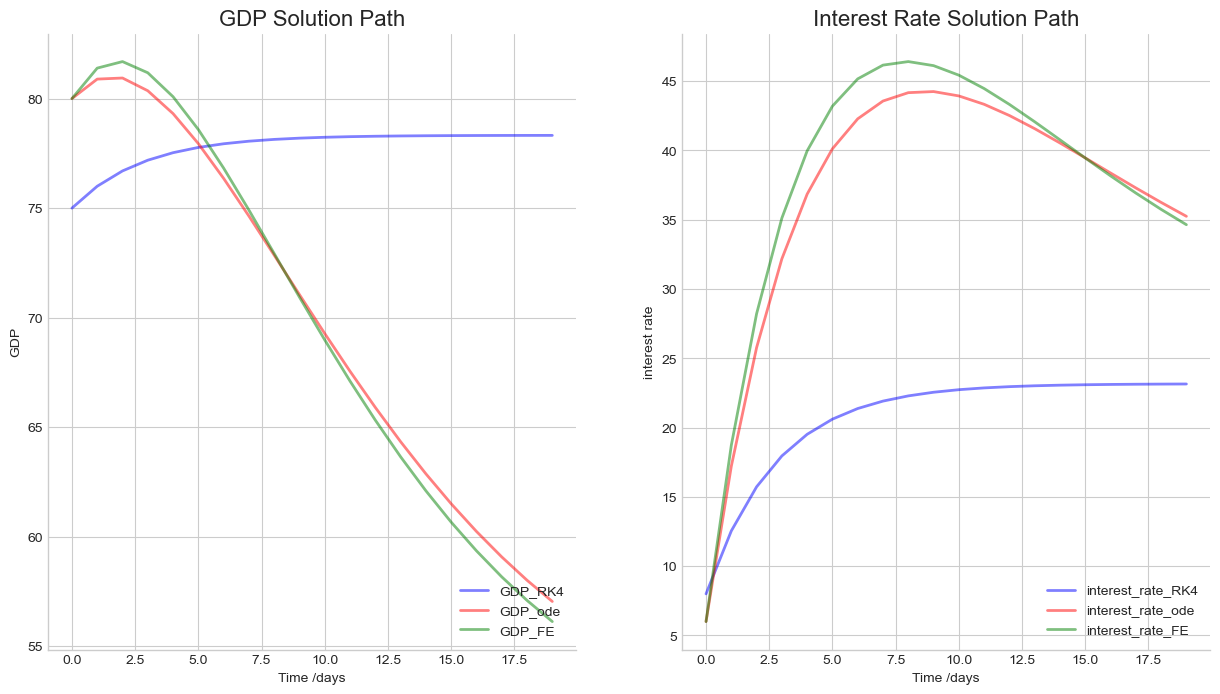

### 4. <a id='toc4_'></a>[Without Government](#toc4_)

Inour first model case we have the follwing due to the lack of government in the model:

$\tau_w=\tau_r=0$, $T_t = G_t = 0$ and $B_t = 0$

**Analytical steady state:** It can be proven that:

$$ \lim_{t\rightarrow\infty} K_t = \left(\frac{1-\alpha}{1+1/\beta}\right)^{\frac{1}{1-\alpha}} $$

We now implement the parameter-values introduced above such that we can simulate the model without government

In [2]:
# We define the model
model = OLGModelClass()
par = model.par # SimpeNamespace
sim = model.sim # SimpeNamespace

# no government
par.tau_w = 0.0
par.tau_r = 0.0
#sim.balanced_budget[:] = True # G changes to achieve this

# steady state and initial values
K_ss_1 = ((1-par.alpha)/((1+1.0/par.beta)))**(1/(1-par.alpha))


### 4.1 <a id='toc4_1_'></a>[Simulation ](#toc4_1_)

We now simulate the model and store the capital and production development

In [3]:
# Simulation
model.simulate()
# steady state production
Y_ss_1 = sim.Y[-1]

# Dataframes that collect model capital and porduciton without government
K_noGov = model.sim.K_lag.copy()
Y_noGOV = model.sim.Y.copy()

### 5 <a id='toc5_'></a>[Model with Government](#toc5_)

With Government we now set the follwing parameter values to be some level > 0:

$\tau_w=0.1$, $\tau_r=0.2$

$T_t = G_t = B_t > 0$

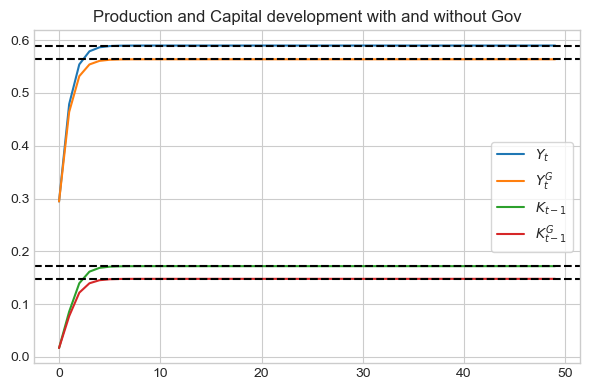

In [7]:
# Call the model again including Government
model = OLGModelClass()
par = model.par
sim = model.sim
model.simulate()

K_ss_2 = sim.Y[-1]
Y_ss_2 = sim.K_lag[-1]

K_Gov = model.sim.K_lag.copy()
Y_GOV = model.sim.Y.copy()

# Illustration of production and capital with and without Gov
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)
ax.plot(Y_noGOV, label=r'$Y_{t}$')
ax.plot(Y_GOV, label=r'$Y_{t}^G$')
ax.plot(K_noGov,label=r'$K_{t-1}$')
ax.plot(K_Gov,label=r'$K_{t-1}^G$')

#steady state
ax.axhline(K_ss_1,ls='--',color='black')
ax.axhline(Y_ss_1,ls='--',color='black')
ax.axhline(K_ss_2,ls='--',color='black')
ax.axhline(Y_ss_2,ls='--',color='black')

# layout formatting
ax.legend(frameon=True)
ax.set_title('Production and Capital development with and without Gov')
fig.tight_layout()


We immediatly see that the steady state values of capital and production are lower in the OlG model with Government.
This implies that the mere existence of a government that imposes taxes and takes on public debt in the OLG model leads to a loss in income as the economy approaches its steady state level.  

### 6 <a id='toc6_'></a>[Affect of Government Spending Spree](#toc6_)

We now assume that the Government is introduced to the economy, after it has reached its steady state level. We then assume that the Government goes on a spending spree for T=3 periods. We evaluate how this affects the steady state level of capital and production.

Text(0.5, 1.0, 'Production and Capital development after spending spree')

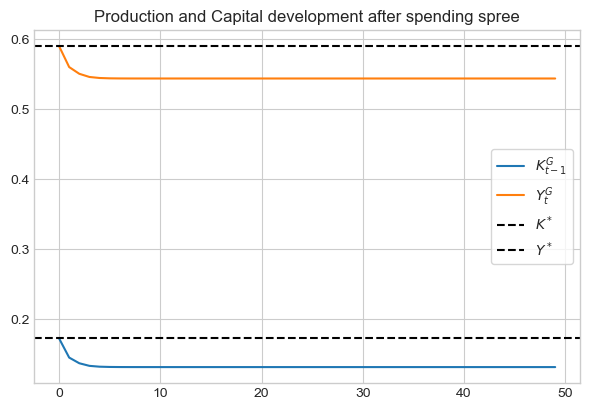

In [10]:
# Government steady state values
B_ss = sim.B_lag[-1]
G_ss = sim.G[-1]

# set the inmitial capital stock to be equal to the noGov steady state level
par.B_lag_ini = B_ss
par.K_lag_ini = K_ss_1

# Government goes on a spending spree
T0 = 0
dT = 3
sim.G[T0:T0+dT] = 1.05*G_ss
sim.balanced_budget[:T0] = True #G adjusts
sim.balanced_budget[T0:T0+dT] = False # B adjusts
sim.balanced_budget[T0+dT:] = True # G adjusts

# simulate economy with spending spree
model.simulate()

# Illustration of production and capital
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)
ax.plot(model.sim.K_lag,label=r'$K_{t-1}^G$')
ax.plot(model.sim.Y, label=r'$Y_{t}^G$')

# steady state
ax.axhline(K_ss_1,ls='--',color='black',label='$K^*$')
ax.axhline(Y_ss_1,ls='--',color='black',label='$Y^*$')

# layout formatting
ax.legend(frameon=True)
ax.set_title('')
fig.tight_layout()
ax.set_title('Production and Capital development after spending spree')

We see that the economies capital and production transition to a lower steady state after the government goes on a three preiod spending spree.

All in all we can conclude from this analysis that the OLG model dynamics imply that when government is introduced, the result is an income loss.
Furthermore we conclude that this income loss can both occur if government is introduced before the economy begins to develop towards its steady state level, and after it has reached its steady state level given that the government goes on a spending spree.